# Persian Question Answering (QA)

### Internship Project – Roshan Company

**Author:** *Mahdy Mokhtari*

**Dataset:** [PersianQA (PQuAD)](https://github.com/sajjjadayobi/PersianQA)

---

### Project Description

This project focuses on the task of **machine reading comprehension (MRC)** in **Persian language**. The system must take a natural language **question** and a supporting **context passage**, then extract the **exact answer span** from the passage.

We will evaluate and fine-tune two Transformer-based models for this purpose:

* **ParsBERT-QuestionAnswering-PQuAD** (Persian-specific BERT variant, already fine-tuned on PersianQA)
* **XLM-RoBERTa-Large (persian\_xlm\_roberta\_large)** (a multilingual model to be fine-tuned for Persian QA)

This mirrors the **SQuAD-style extractive QA** task but adapted to Persian text.

---

### Objectives

1. **Understand the PersianQA dataset** structure and splits.
2. **Evaluate baseline models** on PersianQA (ParsBERT-QA vs. XLM-RoBERTa-Large).
3. **Fine-tune** both models on PersianQA training set.
4. **Compare results** using standard QA metrics:

   * Exact Match (EM)
   * F1 Score
5. Perform **error analysis** to understand failure cases.
6. Document and report findings with clear tables/graphs.

---

### Dataset Structure

* **Format:** JSON/CSV (SQuAD-style) with fields:

  * `context`: supporting passage (paragraph in Persian).
  * `question`: query in Persian.
  * `answer_text`: gold answer string.
  * `answer_start`: start index of answer span in context.
* **Splits:** `train`, `validation`, `test`.
* **Language:** Persian (right-to-left, tokenization challenges).

Example (simplified):

```json
{
  "title": "خوب، بد، زشت",
  "context": "خوب، بد، زشت یک فیلم در ژانر وسترن اسپاگتی ...",
  "question": "در فیلم خوب بد زشت شخصیت ها کجایی صحبت می کنند؟",
  "answer": "مخلوطی از ایتالیایی و انگلیسی"
}

```

---

### Methodology

1. **Data Preprocessing**

   * Normalize Persian script (remove diacritics, handle half-spaces).
   * Tokenize with model’s tokenizer (WordPiece for ParsBERT, SentencePiece for XLM-RoBERTa).
   * Map answer spans to token indices.
   * Truncate/pad inputs to max length (384–512).

2. **Model Setup**

   * Load pretrained checkpoints:

     * `parsbert_question_answering_PQuAD`
     * `xlm-roberta-large` (renamed as `persian_xlm_roberta_large`)
   * Add QA head for start/end position prediction.

3. **Training / Fine-Tuning**

   * Train each model on PersianQA training split.
   * Hyperparameter tuning (batch size, learning rate, epochs).
   * Early stopping on validation F1.

4. **Evaluation**

   * Metrics: Exact Match (EM), F1.
   * Report baseline vs. fine-tuned results.
   * Compare ParsBERT vs. XLM-RoBERTa.

5. **Analysis**

   * Error analysis:

     * Wrong span selection.
     * Unanswerable questions.
     * Context too long → truncation errors.
   * Discuss model strengths/weaknesses for Persian.

---

### Challenges

* **Persian language preprocessing**: half-spaces, diacritics, punctuation.
* **Right-to-left text rendering** in tokenizers & outputs.
* **Large model size (XLM-RoBERTa-Large)** → GPU memory management.
* **Answer span alignment** after tokenization.

---

### Applications

* Persian search engines with direct answer retrieval.
* Intelligent tutoring systems in Farsi.
* Customer support chatbots for Persian users.
* Government/educational QA systems (automated FAQs).

---

### Deliverables

1. **Cleaned dataset pipeline** (tokenization + preprocessing).
2. **Baseline evaluation report** (ParsBERT-QA vs. XLM-R baseline).
3. **Fine-tuned model checkpoints** for both models.
4. **Comparison tables/plots** of EM/F1.
5. **Final internship report** with methodology, results, error analysis, and applications.


## 1. Load Dataset

In [ ]:
# %pip install --force-reinstall --no-cache-dir transformers==4.45.2 datasets
# %pip install -U evaluate
# %pip install accelerate, sentencepiece
# %pip install evaluate accelerate sentencepiece tqdm
# %pip install tensorflow
# %pip install tf-keras



# # import IPython
# # IPython.get_ipython().kernel.do_shutdown(True)

In [ ]:
import transformers, datasets, accelerate, sentencepiece, inspect
print("Transformers:", transformers.__version__)

from transformers import TrainingArguments
print(inspect.signature(TrainingArguments.__init__))

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Transformers: 4.45.2
(self, output_dir: str, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: float = 0.0, warmup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
from datasets import load_dataset, load_from_disk
from pprint import pprint
from collections import OrderedDict
from pathlib import Path
import json, os, glob, subprocess
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk

# --- Config paths/IDs ---
HF_DATASET       = "SajjadAyoubi/persian_qa"  # may fail (deprecated script)
SAVE_DIR         = "/content/drive/MyDrive/ML_Datasets/persianqa_raw"  # persistent Drive cache
LOCAL_CACHE_DIR  = "/content/persianqa_local_cache"                    # fast on-session cache
REPO_URL         = "https://github.com/sajjjadayobi/PersianQA.git"
REPO_DIR         = "/content/PersianQA"

### smart load

In [ ]:
# --- owner’s guaranteed functions ---
def c2dict(ds):
    """ convert dataset (list of dicts) to OrderedDict of fields """
    return OrderedDict([
        ('answers',  [i['answers']  for i in ds]),
        ('context',  [i['context']  for i in ds]),
        ('question', [i['question'] for i in ds])
    ])

def read_qa(path):
    """
    Read dataset from SQuAD-style JSON files (PersianQA, SQuAD2.0, etc.)
    Returns list of dicts.
    """
    ds = []
    with open(Path(path), encoding="utf-8") as f:
        squad = json.load(f)
    for example in squad["data"]:
        title = example.get("title", "").strip()
        for paragraph in example["paragraphs"]:
            for qa in paragraph["qas"]:
                answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                answers = [answer["text"].strip() for answer in qa["answers"]]
                ds.append({
                  "title": title,
                  "context": paragraph["context"].strip(),
                  "question": qa["question"].strip(),
                  "id": qa["id"],
                  "answers": {
                      "answer_start": answer_starts,
                      "text": answers},
                })
    return ds

# --- helpers ---
def build_hf_dataset(train=None, validation=None, test=None):
    """Convert lists of dicts into a DatasetDict"""
    dd = DatasetDict()
    if train:      dd["train"] = Dataset.from_list(train)
    if validation: dd["validation"] = Dataset.from_list(validation)
    if test:       dd["test"] = Dataset.from_list(test)
    return dd

def find_local_jsons(root="."):
    """Look for pqa_train.json, pqa_dev.json, pqa_valid.json, pqa_test.json (case-insensitive)."""
    patterns = ["pqa_train.json", "pqa_dev.json", "pqa_valid.json", "pqa_test.json"]
    found = {}
    for p in patterns:
        matches = glob.glob(os.path.join(root, "**", p), recursive=True)
        if matches:
            key = "train" if "train" in p else "validation" if ("dev" in p or "valid" in p) else "test"
            found[key] = matches[0]
    return found

def load_from_local_jsons(root="."):
    """Load PersianQA from local JSONs using read_qa()"""
    paths = find_local_jsons(root)
    if not paths:
        raise FileNotFoundError(f"No pqa_*.json files found under {root}")

    train = read_qa(paths.get("train")) if "train" in paths else None
    valid = read_qa(paths.get("validation")) if "validation" in paths else None
    test  = read_qa(paths.get("test")) if "test" in paths else None

    return build_hf_dataset(train=train, validation=valid, test=test)

def clone_repo_if_needed():
    """Clone the official PersianQA repo if not already present."""
    if not os.path.exists(REPO_DIR):
        print("Cloning PersianQA repo...")
        # shallow clone for speed
        subprocess.run(["git", "clone", "--depth", "1", "--quiet", REPO_URL, REPO_DIR], check=True)
    else:
        print("PersianQA repo already present.")

def _ensure_persist(dd: DatasetDict):
    """Persist to both Drive and a fast local cache, then return dd."""
    os.makedirs(os.path.dirname(SAVE_DIR), exist_ok=True)
    os.makedirs(LOCAL_CACHE_DIR, exist_ok=True)
    # Save to both locations (arrow format)
    dd.save_to_disk(SAVE_DIR)
    dd.save_to_disk(LOCAL_CACHE_DIR)
    print(f"💾 Saved to Drive: {SAVE_DIR}")
    print(f"⚡ Saved to local cache: {LOCAL_CACHE_DIR}")
    return dd

In [ ]:
def load_persianqa() -> DatasetDict:
    # 1) Local JSONs in current Colab environment
    try:
        print("Looking for local SQuAD-style JSON files in Colab session...")
        dd = load_from_local_jsons(".")
        print(f"💾 Caching to Drive: {SAVE_DIR}")
        dd.save_to_disk(SAVE_DIR)
        return dd
    except Exception as e:
        print("No local JSONs found:", str(e))

    # 2) Drive cache
    if os.path.exists(SAVE_DIR):
        print("Found dataset in Drive. Loading from there...")
        return load_from_disk(SAVE_DIR)

    # 3) Hugging Face Hub (may fail because of old script format)
    try:
        print("Trying to download from Hugging Face Hub...")
        dd = load_dataset(HF_DATASET)
        print(f"💾 Caching to Drive: {SAVE_DIR}")
        dd.save_to_disk(SAVE_DIR)
        return dd
    except Exception as e:
        print("HF Hub load failed, falling back to GitHub clone:", str(e))

    # 4) GitHub fallback
    clone_repo_if_needed()
    dd = load_from_local_jsons(REPO_DIR)
    print(f"💾 Caching to Drive: {SAVE_DIR}")
    dd.save_to_disk(SAVE_DIR)
    return dd


In [ ]:
# ==== run it ====
raw_ds = load_persianqa()
raw_ds

Looking for local SQuAD-style JSON files in Colab session...
No local JSONs found: No pqa_*.json files found under .
Trying to download from Hugging Face Hub...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

persian_qa.py: 0.00B [00:00, ?B/s]

HF Hub load failed, falling back to GitHub clone: Dataset scripts are no longer supported, but found persian_qa.py
Cloning PersianQA repo...
💾 Caching to Drive: /content/drive/MyDrive/ML_Datasets/persianqa_raw


Saving the dataset (0/1 shards):   0%|          | 0/9008 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/930 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers'],
        num_rows: 9008
    })
    test: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers'],
        num_rows: 930
    })
})

### inspect schema

In [ ]:
for split in raw_ds.keys():
    print(f"\n=== {split.upper()} FEATURES ===")
    pprint(raw_ds[split].features)



=== TRAIN FEATURES ===
{'answers': {'answer_start': List(Value('int64')),
             'text': List(Value('string'))},
 'context': Value('string'),
 'id': Value('int64'),
 'question': Value('string'),
 'title': Value('string')}

=== TEST FEATURES ===
{'answers': {'answer_start': List(Value('int64')),
             'text': List(Value('string'))},
 'context': Value('string'),
 'id': Value('int64'),
 'question': Value('string'),
 'title': Value('string')}


### few exmaples

In [ ]:
def show_sample(ds, idx=0, ctx_chars=300):
    ex = ds[idx]
    print("TITLE:\n ", ex.get("title"))
    print("QUESTION:\n ", ex.get("question"))
    ctx = ex.get("context", "") or ""
    print(f"CONTEXT (first {ctx_chars} chars):\n ", ctx[:ctx_chars], "...")
    print("ANSWERS (raw):")
    pprint(ex.get("answers"))
    print("-" * 80)

for split in raw_ds.keys():
    print(f"\n########## {split.upper()} — SAMPLE 0 ##########")
    show_sample(raw_ds[split], idx=0)
    print('-----------------------')
    show_sample(raw_ds[split], idx=1)
    print('-----------------------')
    show_sample(raw_ds[split], idx=9)



########## TRAIN — SAMPLE 0 ##########
TITLE:
  شرکت فولاد مبارکه اصفهان
QUESTION:
  شرکت فولاد مبارکه در کجا واقع شده است
CONTEXT (first 300 chars):
  شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی خصوصی در ایران و بزرگ‌ترین مجتمع تولید فولاد در کشور ایران است، که در شرق شهر مبارکه قرار دارد. فولاد مبارکه هم‌اکنون محرک بسیاری از صنایع بالادستی و پایین‌دستی است. فولاد مبارکه در ۱۱ دوره جایزۀ ملی تعالی سازمانی و ۶ دوره جایزۀ شرکت دانشی در کشور رتبۀ  ...
ANSWERS (raw):
{'answer_start': [114], 'text': ['در شرق شهر مبارکه']}
--------------------------------------------------------------------------------
-----------------------
TITLE:
  شرکت فولاد مبارکه اصفهان
QUESTION:
  فولاد مبارکه چند بار برنده جایزه شرکت دانشی را کسب کرده است؟
CONTEXT (first 300 chars):
  شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی خصوصی در ایران و بزرگ‌ترین مجتمع تولید فولاد در کشور ایران است، که در شرق شهر مبارکه قرار دارد. فولاد مبارکه هم‌اکنون محرک بسیاری از صنایع بالادستی و پایین‌دستی است. فولاد مبارکه در ۱۱

In [ ]:
for split in raw_ds.keys():
    print(f"{split}: {len(raw_ds[split])} examples")


train: 9008 examples
test: 930 examples


## 2. EDA

We performed EDA on the PersianQA dataset with the following steps:

1. **Basic overview** → number of examples per split, sample preview.  
2. **Core statistics** → context/question length, answers per question, answer span validity.  
3. **Integrity checks** → empty answers, span mismatches.  
4. **Length distributions** → histograms of context, question, and answer lengths.  
5. **Duplicate & leakage check** → within-split duplicates and train–test overlap.  
6. **Tokenizer overflow check** → estimate of truncation risk at chosen `max_length` and `doc_stride`.  


In [ ]:
import math, re, statistics, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from datasets import DatasetDict

# Pretty printing
pd.set_option("display.max_colwidth", 120)

def word_count(text):
    return len(str(text).split())

def char_count(text):
    return len(str(text))

def answer_len_chars(ex):
    return [len(t) for t in ex["answers"]["text"]] if ex["answers"]["text"] else [0]

def has_valid_span(ex):
    # True if every answer text matches context substring at its start index
    ctx = ex["context"]
    starts = ex["answers"]["answer_start"]
    texts  = ex["answers"]["text"]
    return all(0 <= s < len(ctx) and ctx[s:s+len(t)] == t for s, t in zip(starts, texts))


### Basic overview

In [ ]:
print("Splits:", list(raw_ds.keys()))
for split in raw_ds.keys():
    print(f"{split}: {len(raw_ds[split])} examples")

for split in raw_ds.keys():
    print(f"\n=== {split.upper()} preview ===")
    display(raw_ds[split].to_pandas().head(3)[["title","question","context","answers"]])


Splits: ['train', 'test']
train: 9008 examples
test: 930 examples

=== TRAIN preview ===


,title,question,context,answers
0,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکه در کجا واقع شده است,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی خصوصی در ایران و بزرگ‌ترین مجتمع تولید فولاد در کشور ایران است، که در...,"{'answer_start': [114], 'text': ['در شرق شهر مبارکه']}"
1,شرکت فولاد مبارکه اصفهان,فولاد مبارکه چند بار برنده جایزه شرکت دانشی را کسب کرده است؟,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی خصوصی در ایران و بزرگ‌ترین مجتمع تولید فولاد در کشور ایران است، که در...,"{'answer_start': [263], 'text': ['۶']}"
2,شرکت فولاد مبارکه اصفهان,شرکت فولاد مبارکه در سال ۱۳۹۱ چه جایزه ای برد؟,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی خصوصی در ایران و بزرگ‌ترین مجتمع تولید فولاد در کشور ایران است، که در...,"{'answer_start': [413], 'text': ['تندیس زرین جایزۀ ملی تعالی سازمانی']}"



=== TEST preview ===


,title,question,context,answers
0,باشگاه فوتبال رئال مادرید,پایتخت اسپانیا کجاست؟,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فوتبال است که در مادرید، پایتخت اسپانیا قرار دارد. رئال موفق‌ترین تیم تا...,"{'answer_start': [19, 19], 'text': ['مادرید', 'مادرید']}"
1,باشگاه فوتبال رئال مادرید,بر چه اساسی رئال موفق ترین تیم در تاریخ فوتبال اروپا است؟,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فوتبال است که در مادرید، پایتخت اسپانیا قرار دارد. رئال موفق‌ترین تیم تا...,"{'answer_start': [218, 208], 'text': ['فیفا', 'به انتخاب فیفا']}"
2,باشگاه فوتبال رئال مادرید,رئال مادرید چند بار در لیگ قهرمانان اروپا به عنوان قهرمانی رسیده؟,باشگاه فوتبال رئال مادرید یک باشگاه حرفه‌ای فوتبال است که در مادرید، پایتخت اسپانیا قرار دارد. رئال موفق‌ترین تیم تا...,"{'answer_start': [329, 329], 'text': ['۱۳', '۱۳']}"


### Core stats per split

In [ ]:
import numpy as np

def _as_list(x):
    """Return x as a Python list (handles None, list/tuple, numpy arrays)."""
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    try:
        return list(np.asarray(x, dtype=object).tolist())
    except Exception:
        return [x]

def answer_len_chars(ex):
    ans = ex.get("answers", {})
    texts = _as_list(ans.get("text", [])) if isinstance(ans, dict) else []
    return [len(t) for t in texts] if len(texts) > 0 else [0]

def has_valid_span(ex):
    ctx = ex.get("context", "")
    ans = ex.get("answers", {})
    if not isinstance(ans, dict):
        return False
    starts = _as_list(ans.get("answer_start", []))
    texts  = _as_list(ans.get("text", []))
    m = min(len(starts), len(texts))
    starts, texts = starts[:m], texts[:m]
    for s, t in zip(starts, texts):
        # guard types/ranges
        if not isinstance(s, (int, np.integer)):
            return False
        if s < 0 or s + len(t) > len(ctx):
            return False
        if ctx[s:s+len(t)] != t:
            return False
    return True

def split_stats(ds_split):
    df = ds_split.to_pandas()

    # lengths
    ctx_chars = df["context"].map(lambda x: len(str(x)))
    q_chars   = df["question"].map(lambda x: len(str(x)))
    ctx_words = df["context"].map(lambda x: len(str(x).split()))
    q_words   = df["question"].map(lambda x: len(str(x).split()))

    # answers
    ans_ct  = df["answers"].map(lambda a: len(_as_list(a.get("text", []))) if isinstance(a, dict) else 0)
    ans_len = df.apply(lambda r: float(np.mean(answer_len_chars(r))) if isinstance(r["answers"], dict) else 0.0, axis=1)

    # integrity
    valid_span = df.apply(has_valid_span, axis=1)

    return {
        "n_examples": int(len(df)),
        "missing_context": int(df["context"].isna().sum()),
        "missing_question": int(df["question"].isna().sum()),
        "avg_ctx_chars": float(np.mean(ctx_chars)),
        "p95_ctx_chars": float(np.percentile(ctx_chars, 95)),
        "avg_q_chars": float(np.mean(q_chars)),
        "avg_ctx_words": float(np.mean(ctx_words)),
        "p95_ctx_words": float(np.percentile(ctx_words, 95)),
        "avg_q_words": float(np.mean(q_words)),
        "avg_answers_per_q": float(np.mean(ans_ct)),
        "avg_answer_len_chars": float(np.mean(ans_len)),
        "valid_span_rate": float(np.mean(valid_span)),
    }


summary_rows = []
for split in raw_ds.keys():
    row = {"split": split}
    row.update(split_stats(raw_ds[split]))
    summary_rows.append(row)

stats_df = pd.DataFrame(summary_rows)
display(stats_df)



,split,n_examples,missing_context,missing_question,avg_ctx_chars,p95_ctx_chars,avg_q_chars,avg_ctx_words,p95_ctx_words,avg_q_words,avg_answers_per_q,avg_answer_len_chars,valid_span_rate
0,train,9008,0,0,1007.578264,1270.0,35.972691,188.500444,239.0,7.363677,0.700044,33.338477,0.992229
1,test,930,0,0,999.365591,1119.0,34.872043,186.612903,216.0,6.948387,1.400000,19.343011,0.992473


### Integrity checks & check edges

In [ ]:
# Show a few examples where span validation failed (if any)
bad = []
for split in raw_ds.keys():
    df = raw_ds[split].to_pandas()
    mask = ~df.apply(has_valid_span, axis=1)
    if mask.any():
        print(f"\n⚠️ Span mismatches in {split}: {mask.sum()} / {len(df)}")
        bad.append((split, df[mask].head(5)[["question","context","answers"]]))
for s, df_bad in bad:
    print(f"\n=== {s.upper()} | examples with span issues ===")
    display(df_bad)

# Empty-answer questions (should be rare for PersianQA)
for split in raw_ds.keys():
    df = raw_ds[split].to_pandas()
    empty_ans = df["answers"].map(lambda a: len(a.get("text", [])) == 0).sum()
    if empty_ans:
        print(f"⚠️ Empty answers in {split}: {empty_ans}")



⚠️ Span mismatches in train: 70 / 9008

⚠️ Span mismatches in test: 7 / 930

=== TRAIN | examples with span issues ===


,question,context,answers
5,مصرف آب فولاد مبارکه چقدر است؟,شرکت فولاد مبارکۀ اصفهان، بزرگ‌ترین واحد صنعتی خصوصی در ایران و بزرگ‌ترین مجتمع تولید فولاد در کشور ایران است، که در...,"{'answer_start': [728], 'text': ['در کمترین میزان خود، ۱٫۵٪ از دبی زاینده‌رود برابر سالانه ۲۳ میلیون متر مکعب در سال..."
12,تمرکز رشته های علوم کامپیوتر روی چیست؟,علوم رایانه یا علوم کامپیوتر به مجموعهٔ مطالعاتی گفته می‌شود که به زیربناهای نظری، روش‌های طراحی و ساخت و چگونگی است...,"{'answer_start': [507], 'text': ['بر چالش‌های موجود در اجرای محاسبات']}"
13,اولین مکان علمی که عبارت داده شناسی را استفاده کرد کجا بود؟,علوم رایانه یا علوم کامپیوتر به مجموعهٔ مطالعاتی گفته می‌شود که به زیربناهای نظری، روش‌های طراحی و ساخت و چگونگی است...,"{'answer_start': [630], 'text': ['دانشگاه کپنهاگ']}"
16,اولین گروه داده‌شناسی توسط چه کسی و در چه سالی بنا شد؟,علوم رایانه یا علوم کامپیوتر به مجموعهٔ مطالعاتی گفته می‌شود که به زیربناهای نظری، روش‌های طراحی و ساخت و چگونگی است...,"{'answer_start': [662], 'text': ['پیتر ناور در سال ۱۹۶۹']}"
23,اسپارکو تولید کدام کارخانه است؟,رُبات ماشینی است که معمولاً قابل برنامه‌ریزی توسط رایانه بوده و قادر به انجام خودکار شماری از اعمال پیچیده است. در س...,"{'answer_start': [326], 'text': ['شرکت وستینگهاوس']}"



=== TEST | examples with span issues ===


,question,context,answers
810,دستگاه حسی-پیکری چیه؟,بخشی از دستگاه حسی است. دستگاه حسی-پیکری مجموعه پیچیده ای از نورون های حسی و مسیرهای عصبی است که به تغییرات در سطح ی...,"{'answer_start': [25, 1], 'text': ['دستگاه حسی-پیکری مجموعه پیچیده ای از نورون های حسی و مسیرهای عصبی است که به تغیی..."
811,احساسات سومستتیک کدامند؟ن,بخشی از دستگاه حسی است. دستگاه حسی-پیکری مجموعه پیچیده ای از نورون های حسی و مسیرهای عصبی است که به تغییرات در سطح ی...,"{'answer_start': [713, 587], 'text': ['حس لامسه، حس عمقی (حس موقعیت و حرکت)، و (بسته به کاربرد) حس هپتیک.', 'حس‌های ..."
812,کار آکسون‌ها را بنویسید؟,بخشی از دستگاه حسی است. دستگاه حسی-پیکری مجموعه پیچیده ای از نورون های حسی و مسیرهای عصبی است که به تغییرات در سطح ی...,"{'answer_start': [143, 153], 'text': ['آکسون‌ها (به عنوان الیاف عصبی آوران) نورون‌های حسی به سلول های گیرنده مختلفی ..."
813,سوماتوتوپی یعنی چه؟,بخشی از دستگاه حسی است. دستگاه حسی-پیکری مجموعه پیچیده ای از نورون های حسی و مسیرهای عصبی است که به تغییرات در سطح ی...,"{'answer_start': [780, 780], 'text': ['نگاشت سطوح بدن در مغز را بدن-نگاری (سوماتوتوپی) می نامند.', 'نگاشت سطوح بدن د..."
814,آیا نقشه سطح مغزی ثابت است؟,بخشی از دستگاه حسی است. دستگاه حسی-پیکری مجموعه پیچیده ای از نورون های حسی و مسیرهای عصبی است که به تغییرات در سطح ی...,"{'answer_start': [927, 927], 'text': ['نقشه سطح مغزی (""قشری"") تغییرناپذیر نیست. براثر سکته یا جراحت ممکن است تغییرات..."


⚠️ Empty answers in train: 2702
⚠️ Empty answers in test: 279


### Length distributions

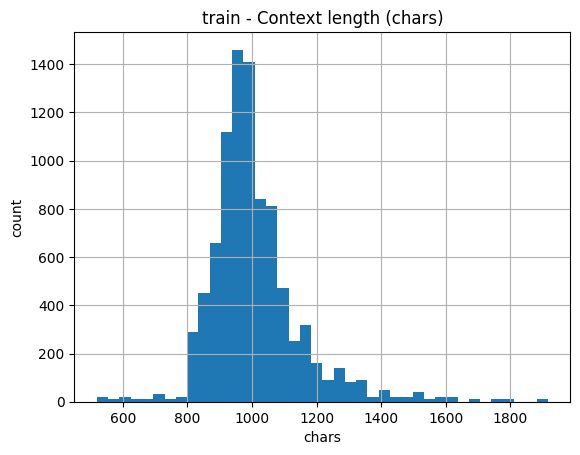

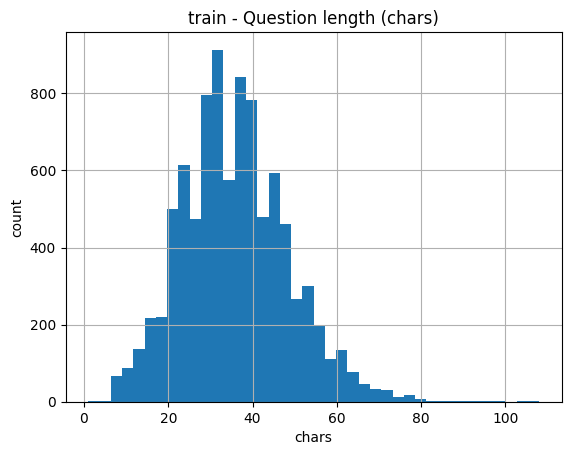

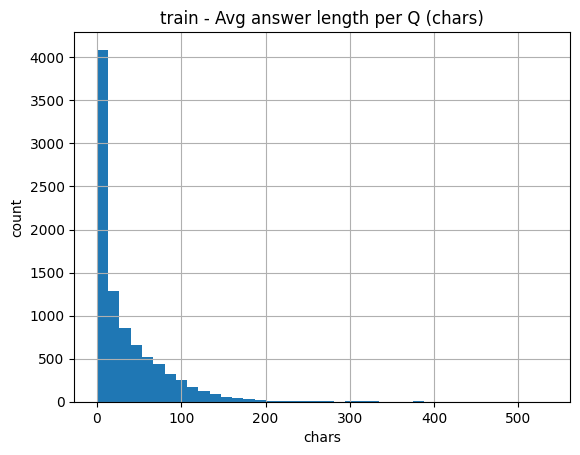

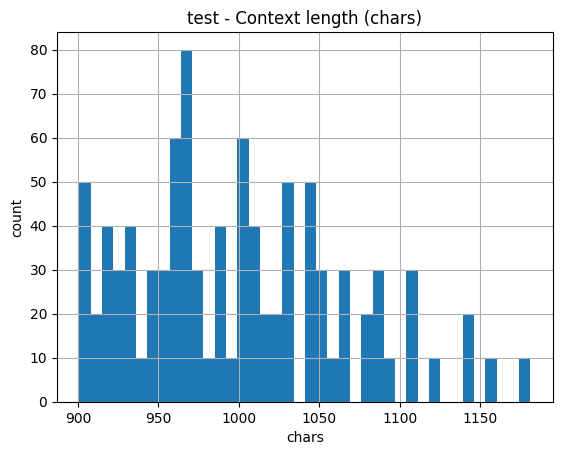

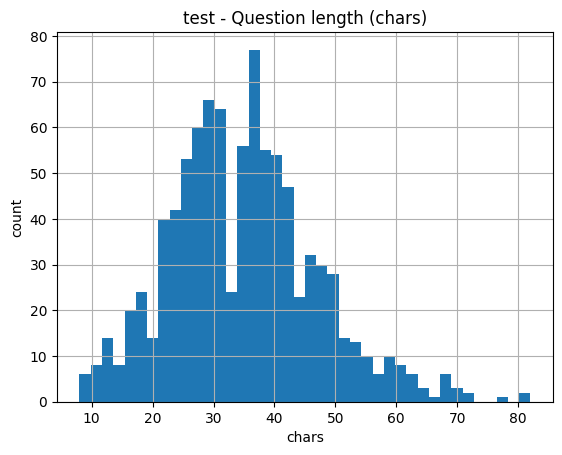

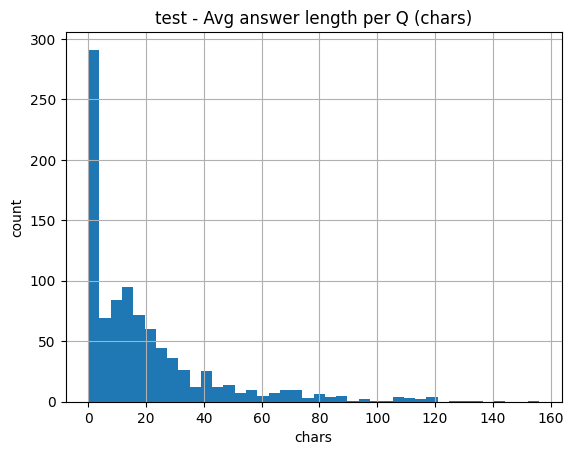

In [ ]:
for split in raw_ds.keys():
    df = raw_ds[split].to_pandas()
    ctx_chars = df["context"].map(char_count)
    q_chars   = df["question"].map(char_count)
    ans_len   = df.apply(lambda r: np.mean(answer_len_chars(r)) if isinstance(r["answers"], dict) else 0, axis=1)

    plt.figure()
    ctx_chars.hist(bins=40)
    plt.title(f"{split} - Context length (chars)")
    plt.xlabel("chars"); plt.ylabel("count"); plt.show()

    plt.figure()
    q_chars.hist(bins=40)
    plt.title(f"{split} - Question length (chars)")
    plt.xlabel("chars"); plt.ylabel("count"); plt.show()

    plt.figure()
    pd.Series(ans_len).hist(bins=40)
    plt.title(f"{split} - Avg answer length per Q (chars)")
    plt.xlabel("chars"); plt.ylabel("count"); plt.show()


### Duplicate leak checks (question + context)

In [ ]:
def dedup_key(row):
    # normalize minimal spaces; keep Persian text untouched otherwise
    q = re.sub(r"\s+", " ", str(row["question"]).strip())
    c = re.sub(r"\s+", " ", str(row["context"]).strip())
    return q + " || " + c

# Intra-split duplicates
for split in raw_ds.keys():
    df = raw_ds[split].to_pandas()
    dkeys = df.apply(dedup_key, axis=1)
    dup_ct = dkeys.duplicated().sum()
    print(f"{split}: intra-split duplicates = {dup_ct}")

# Cross-split leakage: train vs test
if set(raw_ds.keys()) >= {"train","test"}:
    tr = raw_ds["train"].to_pandas().apply(dedup_key, axis=1)
    te = raw_ds["test"].to_pandas().apply(dedup_key, axis=1)
    overlap = len(set(tr).intersection(set(te)))
    print(f"Cross-split overlap (train↔test): {overlap}")


train: intra-split duplicates = 10
test: intra-split duplicates = 0
Cross-split overlap (train↔test): 0


## 3. Data Cleaning & Pre-processing

In [ ]:
import os, re, hashlib, numpy as np
from datasets import DatasetDict

def _as_list(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    try:
        return list(np.asarray(x, dtype=object).tolist())
    except Exception:
        return [x]

def is_answerable(row):
    a = row.get("answers", {})
    if not isinstance(a, dict):
        return False
    texts = _as_list(a.get("text", []))
    # "answerable" only if there is at least one non-empty span
    return len(texts) > 0 and len(str(texts[0]).strip()) > 0

def span_is_valid(row):
    """
    For answerable examples: verify that context[answer_start:...] == answer_text.
    For no-answer examples: return True (we must keep them).
    """
    if not is_answerable(row):
        return True  # keep no-answer examples
    ctx = row.get("context", "")
    a = row["answers"]
    starts = _as_list(a.get("answer_start", []))
    texts  = _as_list(a.get("text", []))
    if len(starts) == 0 or len(texts) == 0:
        return False
    s, t = int(starts[0]), str(texts[0])
    if s < 0 or s + len(t) > len(ctx):
        return False
    return ctx[s:s+len(t)] == t

def key_qc(row):
    # Key for dedup: (question, context) normalized whitespace
    q = re.sub(r"\s+", " ", str(row["question"]).strip())
    c = re.sub(r"\s+", " ", str(row["context"]).strip())
    return hashlib.md5((q + " || " + c).encode("utf-8")).hexdigest()


Make a 10% validation split from TRAIN (keep TEST unseen)

In [ ]:
# Split 10% of TRAIN into VALIDATION (reproducible)
split = raw_ds["train"].train_test_split(test_size=0.10, seed=42, shuffle=True)
train_ds = split["train"]
val_ds   = split["test"]   # our validation

# Keep original TEST fully unseen (if present)
new_ds = DatasetDict({"train": train_ds, "validation": val_ds})
if "test" in raw_ds:
    new_ds["test"] = raw_ds["test"]

for k in new_ds.keys():
    print(f"{k}: {len(new_ds[k])} examples")
raw_ds = new_ds  # use this from now on


train: 8107 examples
validation: 901 examples
test: 930 examples


Drop only answerable examples with bad spans (keep no-answer)

In [ ]:
def keep_row_span_ok(row):
    return span_is_valid(row)

clean_ds = DatasetDict({
    split: raw_ds[split].filter(keep_row_span_ok)
    for split in raw_ds.keys()
})

for k in clean_ds:
    print(f"{k}: kept {len(clean_ds[k])} after span check (no-answer preserved)")


Filter:   0%|          | 0/8107 [00:00<?, ? examples/s]

Filter:   0%|          | 0/901 [00:00<?, ? examples/s]

Filter:   0%|          | 0/930 [00:00<?, ? examples/s]

train: kept 8047 after span check (no-answer preserved)
validation: kept 891 after span check (no-answer preserved)
test: kept 923 after span check (no-answer preserved)


Deduplicate within splits & remove leakage between splits

In [ ]:
# --- Intra-split dedup (per split)
def drop_duplicates(ds):
    seen = set()
    def _keep(r):
        k = key_qc(r)
        if k in seen:
            return False
        seen.add(k)
        return True
    # NOTE: don't use num_proc here; the closure 'seen' isn't shared across workers
    return ds.filter(_keep)

for sp in list(clean_ds.keys()):
    clean_ds[sp] = drop_duplicates(clean_ds[sp])

# --- Cross-split leakage removal (remove val/test items that appear in train)
# Build a temporary column via map (map must return a dict/pyarrow table)
train_with_keys = clean_ds["train"].map(lambda ex: {"qc_key": key_qc(ex)})
train_keys = set(train_with_keys["qc_key"])

clean_ds["validation"] = clean_ds["validation"].filter(lambda ex: key_qc(ex) not in train_keys)

if "test" in clean_ds:
    clean_ds["test"] = clean_ds["test"].filter(lambda ex: key_qc(ex) not in train_keys)

# --- Report sizes
for split_name, ds in clean_ds.items():
    print(f"{split_name}: {len(ds)} after dedup & de-leak")

Filter:   0%|          | 0/8047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/923 [00:00<?, ? examples/s]

Map:   0%|          | 0/8037 [00:00<?, ? examples/s]

Filter:   0%|          | 0/891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/923 [00:00<?, ? examples/s]

train: 8037 after dedup & de-leak
validation: 891 after dedup & de-leak
test: 923 after dedup & de-leak


Light normalization toggles (OFF by default)

In [ ]:
# If you decide later to normalize text (safe Persian/Arabic char fixes),
# we can enable a small function. Leaving OFF to avoid shifting answer offsets.
APPLY_NORMALIZATION = True

if APPLY_NORMALIZATION:
    PERSIAN_MAP = {"\u064a": "\u06cc", "\u0643": "\u06a9"}
    DIACRITICS = re.compile(r"[\u064B-\u065F\u0670\u06D6-\u06ED]")
    TATWEEL = "\u0640"

    def norm_text(s: str) -> str:
        if not isinstance(s, str): s = str(s)
        s = s.replace(TATWEEL, "")
        s = DIACRITICS.sub("", s)
        s = "".join(PERSIAN_MAP.get(ch, ch) for ch in s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

    def norm_row(r):
        # Do NOT change offsets or content length if answerable — risky.
        # So keep normalization OFF unless you re-align spans afterward.
        return r

    for sp in list(clean_ds.keys()):
        clean_ds[sp] = clean_ds[sp].map(norm_row)
    print("✨ Normalization applied (noop stub).")


Map:   0%|          | 0/8037 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

✨ Normalization applied (noop stub).


In [ ]:
SAVE_CLEAN_DIR = "/content/drive/MyDrive/ML_Datasets/persianqa_clean"
LOCAL_CLEAN    = "/content/persianqa_clean_local"
os.makedirs(SAVE_CLEAN_DIR, exist_ok=True)
os.makedirs(LOCAL_CLEAN, exist_ok=True)

clean_ds.save_to_disk(SAVE_CLEAN_DIR)
clean_ds.save_to_disk(LOCAL_CLEAN)

print("💾 Saved clean dataset.")
for sp in clean_ds:
    print(f"{sp}: {len(clean_ds[sp])} examples")


Saving the dataset (0/1 shards):   0%|          | 0/8037 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/891 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/923 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8037 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/891 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/923 [00:00<?, ? examples/s]

💾 Saved clean dataset.
train: 8037 examples
validation: 891 examples
test: 923 examples


## 4. Tokenization & Feature Prepration

### Token Length Analysis

This section analyzes the dataset to determine the **optimal `max_length` and `doc_stride`** for tokenization.  

- Computes token length percentiles (P50, P90, P95, P99) for questions + contexts.  
- Estimates overflow rate: how many examples get split into multiple chunks.  
- Suggests the best `max_length` + `doc_stride` combination to minimize chunking.  

> **Note:** This step is **optional**. Once optimal values are chosen, it can be skipped in future runs to speed up preprocessing.


In [ ]:
# import numpy as np
# from transformers import AutoTokenizer
# from itertools import product

# MODELS = [
#     "HooshvareLab/bert-base-parsbert-uncased",
#     "xlm-roberta-large"
# ]

# def _col_as_list(ds_split, name):
#     col = ds_split[name]
#     # HuggingFace may return Arrow arrays / tensors depending on format
#     if hasattr(col, "to_pylist"):
#         col = col.to_pylist()
#     elif not isinstance(col, list):
#         col = list(col)
#     # sanitize: ensure strings (replace None, decode bytes)
#     out = []
#     for v in col:
#         if v is None:
#             out.append("")
#         elif isinstance(v, bytes):
#             out.append(v.decode("utf-8", errors="ignore"))
#         else:
#             out.append(str(v))
#     return out

# def token_len_stats(ds_split, tokenizer):
#     q = _col_as_list(ds_split, "question")
#     c = _col_as_list(ds_split, "context")
#     enc = tokenizer(q, c, truncation=False, padding=False)
#     lengths = [len(ids) for ids in enc["input_ids"]]
#     pct = np.percentile(lengths, [50, 90, 95, 99]).round(1)
#     return pct

# def overflow_rate(ds_split, tokenizer, max_length, doc_stride):
#     q = _col_as_list(ds_split, "question")
#     c = _col_as_list(ds_split, "context")
#     enc = tokenizer(
#         q, c,
#         truncation="only_second",
#         max_length=max_length,
#         stride=doc_stride,
#         return_overflowing_tokens=True,
#         padding=False
#     )
#     # how many examples produced >1 chunk?
#     from collections import Counter
#     counts = Counter(enc["overflow_to_sample_mapping"])
#     if not counts:
#         return 0.0
#     n_over = sum(1 for v in counts.values() if v > 1)
#     return n_over / len(counts)

# candidates_len    = [320, 384, 448, 512]
# candidates_stride = [64, 96, 128]

# for model in MODELS:
#     tok = AutoTokenizer.from_pretrained(model, use_fast=True)
#     print(f"\n=== {model} ===")
#     for split in ["train", "validation"]:
#         if split not in clean_ds:
#             continue
#         pct = token_len_stats(clean_ds[split], tok)
#         print(f"{split}: P50={pct[0]}, P90={pct[1]}, P95={pct[2]}, P99={pct[3]}")
#         rows = []
#         for L, S in product(candidates_len, candidates_stride):
#             rate = overflow_rate(clean_ds[split], tok, L, S)
#             rows.append((L, S, rate))
#         rows.sort(key=lambda x: (x[2], x[0]))  # prefer lower overflow, then shorter length
#         best = rows[0]
#         print(f"  best by overflow → max_length={best[0]}, stride={best[1]} (overflow={best[2]:.2%})")
#         print("  summary (top 5):", rows[:5])


In [ ]:
from transformers import AutoTokenizer
from datasets import DatasetDict

# Clean dataset from Step 3
assert isinstance(clean_ds, DatasetDict), "Run Step 3 first to produce `clean_ds`."

MODEL_LIST = [
    "HooshvareLab/bert-base-parsbert-uncased",
    # ParsBERT base: pretrained from scratch on a large Persian corpus
    # (initially initialized from multilingual BERT, then continued ONLY on Persian text).
    # This is a general-purpose language model, NOT QA fine-tuned.

    "xlm-roberta-large",
    # XLM-R Large: a multilingual model trained on 100+ languages (including Persian).
    # This is also a general-purpose model, NOT QA fine-tuned.
]



MODEL_CONFIGS = {
    "HooshvareLab/bert-base-parsbert-uncased": dict(max_length=448, doc_stride=64),
    "xlm-roberta-large": dict(max_length=512, doc_stride=64),  # or 448 if memory is tight
}



In [ ]:
def _context_span(sequence_ids):
    """Return (context_start_idx, context_end_idx) inclusive for this feature."""
    # sequence_ids: list like [None, 0, 0, 1, 1, 1, None, ...]
    try:
        context_start = next(i for i, s in enumerate(sequence_ids) if s == 1)
    except StopIteration:
        return None, None
    # walk to the end of the contiguous context region
    j = context_start
    while j < len(sequence_ids) and sequence_ids[j] == 1:
        j += 1
    context_end = j - 1
    return context_start, context_end


def make_preprocess_train(tokenizer, model_name):
    """
    Map (question, context, answers) -> tokenized features with
    start_positions and end_positions for QA training.

    Behavior:
    - Sliding windows with overflow & stride.
    - If an example has NO answer, every feature gets (CLS, CLS).
    - If an answer does not fall inside a given feature window, we set (CLS, CLS)
      so we never provide incorrect spans.
    """
    cfg = MODEL_CONFIGS[model_name]

    def _fn(examples):
        questions = [q.strip() if isinstance(q, str) else "" for q in examples["question"]]
        contexts  = [c if isinstance(c, str) else "" for c in examples["context"]]

        tokenized = tokenizer(
            questions,
            contexts,
            truncation="only_second",
            max_length=cfg["max_length"],
            stride=cfg["doc_stride"],
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",   # keep fixed shape for labels
        )

        sample_mapping = tokenized.pop("overflow_to_sample_mapping")
        offset_mapping = tokenized.pop("offset_mapping")

        start_positions, end_positions = [], []

        for i, offsets in enumerate(offset_mapping):
            input_ids    = tokenized["input_ids"][i]
            sequence_ids = tokenized.sequence_ids(i)
            cls_index    = input_ids.index(tokenizer.cls_token_id) if tokenizer.cls_token_id in input_ids else 0
            sample_idx   = sample_mapping[i]

            ans = examples["answers"][sample_idx]
            texts  = ans.get("text", []) if isinstance(ans, dict) else []
            starts = ans.get("answer_start", []) if isinstance(ans, dict) else []

            # No-answer → point to CLS for this feature
            if not texts or not str(texts[0]).strip():
                start_positions.append(cls_index)
                end_positions.append(cls_index)
                continue

            # Target character span in the original context
            start_char = int(starts[0])
            end_char   = start_char + len(str(texts[0]))

            # Context token span in THIS feature
            c_start, c_end = _context_span(sequence_ids)
            if c_start is None or c_end is None:
                # No context tokens in this feature (shouldn't happen with only_second)
                start_positions.append(cls_index)
                end_positions.append(cls_index)
                continue

            # Find token indices that cover [start_char, end_char)
            s_tok = e_tok = None
            for j in range(c_start, c_end + 1):
                off = offsets[j]
                if off is None:  # special/padded
                    continue
                start_off, end_off = off
                if s_tok is None and start_off <= start_char < end_off:
                    s_tok = j
                if s_tok is not None and start_off < end_char <= end_off:
                    e_tok = j
                    break

            # If answer not fully inside this window → assign CLS
            if s_tok is None or e_tok is None:
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                start_positions.append(s_tok)
                end_positions.append(e_tok)

        tokenized["start_positions"] = start_positions
        tokenized["end_positions"]   = end_positions
        return tokenized

    return _fn


def make_preprocess_eval(tokenizer, model_name):
    """
    Map (question, context) -> tokenized eval features with:
    - example_id (use original id if available, else integer index)
    - offset_mapping pruned to context tokens only (others = None)

    Use padding=False to keep true offsets; batching later will pad.
    """
    cfg = MODEL_CONFIGS[model_name]

    def _fn(examples):
        questions = [q.strip() if isinstance(q, str) else "" for q in examples["question"]]
        contexts  = [c if isinstance(c, str) else "" for c in examples["context"]]

        tokenized = tokenizer(
            questions,
            contexts,
            truncation="only_second",
            max_length=cfg["max_length"],
            stride=cfg["doc_stride"],
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding=False,   # important: preserve real offsets
        )

        sample_mapping = tokenized.pop("overflow_to_sample_mapping")
        example_ids = []
        new_offsets = []

        has_ids = "id" in examples

        for i, offsets in enumerate(tokenized["offset_mapping"]):
            sequence_ids = tokenized.sequence_ids(i)
            # keep offsets only for context tokens; others → None
            pruned = [(o if sequence_ids[k] == 1 else None) for k, o in enumerate(offsets)]
            new_offsets.append(pruned)

            ex_idx = sample_mapping[i]
            example_ids.append(examples["id"][ex_idx] if has_ids else str(ex_idx))

        tokenized["example_id"]     = example_ids
        tokenized["offset_mapping"] = new_offsets
        return tokenized

    return _fn


### Actual Tokenization loop

This section **tokenizes the dataset** for each model in `MODEL_LIST`.  

- Uses the **fast tokenizer** from HuggingFace for each model.  
- Applies `make_preprocess_train` to training data and `make_preprocess_eval` to validation/test data.  
- Removes unnecessary columns after tokenization.  
- Stores tokenized datasets and tokenizers in `tokenized_by_model` for easy access.  

> **Output:** Number of tokenized features per split (`train`, `validation`, `test`) is displayed for quick inspection.


In [ ]:
tokenized_by_model = {}

for model_name in MODEL_LIST:
    print(f"\n=== Tokenizing for {model_name} ===")
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    cols = clean_ds["train"].column_names if "train" in clean_ds else list(clean_ds.values())[0].column_names
    tokenized = DatasetDict()

    if "train" in clean_ds:
        tokenized["train"] = clean_ds["train"].map(
            make_preprocess_train(tok, model_name),
            batched=True,
            remove_columns=cols,
        )
    if "validation" in clean_ds:
        tokenized["validation"] = clean_ds["validation"].map(
            make_preprocess_eval(tok, model_name),
            batched=True,
            remove_columns=cols,
        )
    if "test" in clean_ds:
        tokenized["test"] = clean_ds["test"].map(
            make_preprocess_eval(tok, model_name),
            batched=True,
            remove_columns=cols,
        )

    tokenized_by_model[model_name] = {"tokenizer": tok, "dataset": tokenized}

    # quick summary
    for sp in tokenized.keys():
        print(f"{sp}: {len(tokenized[sp])} features")

# Example access:
# tokenized_by_model["HooshvareLab/bert-base-parsbert-uncased"]["dataset"]["train"]



=== Tokenizing for HooshvareLab/bert-base-parsbert-uncased ===


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/8037 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

train: 8047 features
validation: 891 features
test: 923 features

=== Tokenizing for xlm-roberta-large ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/8037 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

Map:   0%|          | 0/923 [00:00<?, ? examples/s]

train: 8056 features
validation: 892 features
test: 923 features


In [ ]:
# Inspect one training feature from ParsBERT
pb = tokenized_by_model["HooshvareLab/bert-base-parsbert-uncased"]["dataset"]["train"][0]
print("ParsBERT train keys:", pb.keys())
print("start/end:", pb["start_positions"], pb["end_positions"])

# Inspect one eval feature from XLM-R (if present)
if "validation" in tokenized_by_model["xlm-roberta-large"]["dataset"]:
    xr = tokenized_by_model["xlm-roberta-large"]["dataset"]["validation"][0]
    print("XLM-R val keys:", xr.keys())
    print("example_id:", xr["example_id"])
    print("first 8 offsets:", xr["offset_mapping"][:8])


ParsBERT train keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
start/end: 0 0
XLM-R val keys: dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'example_id'])
example_id: 708
first 8 offsets: [None, None, None, None, None, None, None, None]


## 5. Model Setup (ParsBert)

In [ ]:
# import transformers
# print(transformers.__version__)


In [ ]:
# from transformers import AutoModelForQuestionAnswering
# import torch

# parsbert_model_name = "HooshvareLab/bert-base-parsbert-uncased"

# base_model_parsbert = AutoModelForQuestionAnswering.from_pretrained(
#     parsbert_model_name,
#     num_labels=2  # start and end
# )

# device = "cuda" if torch.cuda.is_available() else "cpu"
# base_model_parsbert.to(device)

# print(device)

In [ ]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./parsbert-qa-checkpoints",
#     evaluation_strategy="steps",   # run eval during training
#     save_strategy="steps",
#     learning_rate=3e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_steps=100,
#     eval_steps=500,
#     save_steps=500,
#     load_best_model_at_end=False,
#     metric_for_best_model=None,    # we’ll define F1 later
#     greater_is_better=True,
#     report_to="none",              # or "wandb"/"tensorboard"
# )


In [ ]:
# from transformers import DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tok)


In [ ]:
# # Robust metric loader: datasets (old) -> evaluate (new)
# try:
#     from datasets import load_metric  # old API
#     metric = load_metric("squad_v2")
# except Exception:
#     import evaluate
#     metric = evaluate.load("squad_v2")

# from sklearn.metrics import f1_score
# from transformers import EvalPrediction

# def compute_metrics(p: EvalPrediction):
#     preds = p.predictions.argmax(-1)   # get class indices
#     labels = p.label_ids
#     f1 = f1_score(labels, preds, average="macro")
#     return {"eval_f1": f1}



In [ ]:
# from transformers import Trainer

# trainer = Trainer(
#     model=base_model_parsbert,
#     args=training_args,
#     train_dataset=tokenized_by_model[parsbert_model_name]["dataset"]["train"],
#     eval_dataset=tokenized_by_model[parsbert_model_name]["dataset"]["validation"],
#     tokenizer=tokenized_by_model[parsbert_model_name]["tokenizer"],
#     data_collator=data_collator,
#     compute_metrics=compute_metrics
# )


## 6. Pre Fine-Tune (Base FaBert Model Evaluation)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
# # =========================
# # Step — Zero-shot baseline (pre-finetuning) evaluation + persistent logging
# # =========================
# import numpy as np
# from collections import defaultdict
# from transformers import Trainer
# from transformers import DataCollatorWithPadding
# from pathlib import Path
# import json, datetime

# # 1) Pick eval split (prefer test; fallback to validation)
# eval_split_name = "test"
# eval_features   = tokenized_by_model[parsbert_model_name]["dataset"][eval_split_name]
# eval_examples   = clean_ds[eval_split_name]  # raw examples with 'answers' (and optional 'id')
# tok             = tokenized_by_model[parsbert_model_name]["tokenizer"]

# # 2) Prediction-only Trainer with dynamic padding collator
# #    IMPORTANT: our eval preprocessing used padding=False → we MUST use dynamic padding here.
# data_collator = DataCollatorWithPadding(tokenizer=tok)  # (optionally pad_to_multiple_of=8 if fp16)
# eval_trainer = Trainer(
#     model=base_model_parsbert,
#     tokenizer=tok,
#     data_collator=data_collator,
# )

# # 3) Predict logits on tokenized FEATURES (not raw examples)
# raw_pred = eval_trainer.predict(eval_features)
# start_logits, end_logits = raw_pred.predictions

# # 4) Post-process logits -> text predictions (supports no-answer via CLS comparison)
# n_best = 20
# max_answer_length = 30
# example_id_key = "example_id"

# def _topk_idx(arr, k):
#     return np.argsort(arr)[-k:][::-1]

# # Group features by original example id
# features_per_example = defaultdict(list)
# for fi, ex_id in enumerate(eval_features[example_id_key]):
#     features_per_example[str(ex_id)].append(fi)

# predictions = {}
# for ex_id, feat_idxs in features_per_example.items():
#     best_text, best_score, best_null = "", -1e10, -1e10
#     for fi in feat_idxs:
#         s_log = start_logits[fi]
#         e_log = end_logits[fi]
#         input_ids = eval_features[fi]["input_ids"]
#         offsets   = eval_features[fi]["offset_mapping"]

#         # CLS = null (no-answer) score
#         try:
#             cls_idx = input_ids.index(tok.cls_token_id)
#         except ValueError:
#             cls_idx = 0
#         best_null = max(best_null, float(s_log[cls_idx] + e_log[cls_idx]))

#         # candidate spans from top-k starts/ends
#         for s in _topk_idx(s_log, n_best):
#             for e in _topk_idx(e_log, n_best):
#                 if e < s or (e - s + 1) > max_answer_length:
#                     continue
#                 if s >= len(offsets) or e >= len(offsets):
#                     continue
#                 if offsets[s] is None or offsets[e] is None:
#                     continue
#                 sc, _ = offsets[s]
#                 _, ec = offsets[e]
#                 if sc is None or ec is None or ec < sc:
#                     continue

#                 score = float(s_log[s] + e_log[e])
#                 if score > best_score:
#                     best_score = score
#                     best_text  = tok.decode(input_ids[s:e+1], skip_special_tokens=True)

#     # choose "" (no-answer) if null >= best span
#     predictions[ex_id] = "" if best_null >= best_score else best_text

# # 5) Build references in SQuAD v2 format and compute metrics
# use_ids = "id" in eval_examples.column_names
# refs = []
# if use_ids:
#     # remap predictions to true example ids
#     remapped = {}
#     for i in range(len(eval_examples)):
#         ex_id = str(eval_examples[i]["id"])
#         remapped[ex_id] = predictions.get(ex_id, predictions.get(str(i), ""))
#         refs.append({"id": ex_id, "answers": eval_examples[i]["answers"]})
#     predictions = remapped
# else:
#     for i in range(len(eval_examples)):
#         refs.append({"id": str(i), "answers": eval_examples[i]["answers"]})
#     predictions = {str(i): predictions.get(str(i), "") for i in range(len(eval_examples))}

# pred_list = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in predictions.items()]
# metrics = metric.compute(predictions=pred_list, references=refs)

# print(f"\n[Zero-shot baseline • {parsbert_model_name} • split={eval_split_name}]")
# print(f"EM: {metrics['exact']:.2f} | F1: {metrics['f1']:.2f}")

# # 6) Persist results and predictions for later comparison
# results_dir = Path("./results")
# results_dir.mkdir(parents=True, exist_ok=True)

# row = {
#     "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
#     "phase": "baseline",                     # baseline vs finetuned
#     "model_name": parsbert_model_name,
#     "split": eval_split_name,
#     "num_examples": len(eval_examples),
#     "em": round(float(metrics["exact"]), 4),
#     "f1": round(float(metrics["f1"]), 4),
#     "tag": "parsbert_baseline",
# }
# with (results_dir / "qa_runs.jsonl").open("a", encoding="utf-8") as f:
#     f.write(json.dumps(row, ensure_ascii=False) + "\n")

# pred_path = results_dir / f"predictions_{parsbert_model_name.replace('/','__')}_{eval_split_name}_baseline.json"
# with pred_path.open("w", encoding="utf-8") as f:
#     json.dump(predictions, f, ensure_ascii=False, indent=2)

# print(f"Saved metrics row to: {results_dir / 'qa_runs.jsonl'}")
# print(f"Saved decoded predictions to: {pred_path}")


## 7. Fine-Tuning FaBert on PersianQA

In [ ]:
# # =========================
# # Step — Fine-tuning ParsBERT on PersianQA (no duplicate setup)
# # =========================

# eval_name = "validation"
# eval_features = tokenized_by_model[parsbert_model_name]["dataset"][eval_name]
# tok = tokenized_by_model[parsbert_model_name]["tokenizer"]

# train_out = trainer.train()
# print("\n[train] final training loss:", float(train_out.training_loss))

# trainer.save_model("./parsbert-qa-best")
# tok.save_pretrained("./parsbert-qa-best")



## 8. Post Processing

**Why we need post‑processing ?**

The model outputs start/end logits (scores per token position), not text. Post‑processing does three essential things:

Span selection: chooses a valid (start, end) pair within the context and limits answer length.

No‑answer handling: compares the best span score to the CLS (null) score to decide if the answer is actually empty.

Decoding: converts subword IDs back into readable text for evaluation and reporting.

Without post‑processing, you only have raw scores—no actual answers to compare against the gold labels (EM/F1).

In [ ]:
# # =========================
# # Step — Post-processing (logits -> decoded answers)
# # =========================
# import numpy as np
# from collections import defaultdict

# def _topk_idx(arr, k):
#     return np.argsort(arr)[-k:][::-1]

# def postprocess_qa_predictions(
#     trainer,
#     features,
#     tokenizer,
#     n_best=20,
#     max_answer_len=30,
#     example_id_key="example_id",
# ):
#     """
#     Convert start/end logits -> text answers per example.
#     Returns: dict[str example_id] -> str predicted_text ("" means no-answer).
#     """
#     # 1) Run inference over *features* (already tokenized with offsets)
#     raw_pred = trainer.predict(features)
#     start_logits, end_logits = raw_pred.predictions

#     # 2) Group feature indices by their original example id
#     feats_by_ex = defaultdict(list)
#     for fi, ex_id in enumerate(features[example_id_key]):
#         feats_by_ex[str(ex_id)].append(fi)

#     # 3) For each example, pick the best span vs. the null (CLS) option
#     predictions = {}
#     for ex_id, idxs in feats_by_ex.items():
#         best_text = ""
#         best_span_score = -1e10
#         best_null_score = -1e10

#         for fi in idxs:
#             s_log = start_logits[fi]
#             e_log = end_logits[fi]
#             input_ids = features[fi]["input_ids"]
#             offsets   = features[fi]["offset_mapping"]

#             # CLS = null (no-answer) score
#             try:
#                 cls_idx = input_ids.index(tokenizer.cls_token_id)
#             except ValueError:
#                 cls_idx = 0
#             best_null_score = max(best_null_score, float(s_log[cls_idx] + e_log[cls_idx]))

#             # Candidate spans from top-k starts/ends
#             for s in _topk_idx(s_log, n_best):
#                 for e in _topk_idx(e_log, n_best):
#                     if e < s or (e - s + 1) > max_answer_len:
#                         continue
#                     if s >= len(offsets) or e >= len(offsets):
#                         continue
#                     if offsets[s] is None or offsets[e] is None:
#                         continue
#                     sc, _ = offsets[s]
#                     _, ec = offsets[e]
#                     if sc is None or ec is None or ec < sc:
#                         continue

#                     span_score = float(s_log[s] + e_log[e])
#                     if span_score > best_span_score:
#                         best_span_score = span_score
#                         best_text = tokenizer.decode(input_ids[s:e+1], skip_special_tokens=True)

#         # Null-vs-span decision (threshold = 0)
#         predictions[ex_id] = "" if best_null_score >= best_span_score else best_text

#     return predictions

# # --- Example usage (ParsBERT validation features) ---
# parsbert_model_name = "HooshvareLab/bert-base-parsbert-uncased"
# eval_name = "validation" if "validation" in tokenized_by_model[parsbert_model_name]["dataset"] else "train"
# eval_features = tokenized_by_model[parsbert_model_name]["dataset"][eval_name]
# tok = tokenized_by_model[parsbert_model_name]["tokenizer"]

# preds_by_id = postprocess_qa_predictions(
#     trainer=trainer,
#     features=eval_features,
#     tokenizer=tok,
# )

# # Peek a few decoded predictions
# list(preds_by_id.items())[:5]


## 9. Evaluation

In [ ]:
# # =========================
# # Step — Evaluation on test + persistent logging
# # =========================
# import os, json, datetime
# from pathlib import Path

# # Choose split: prefer "test", else "validation"
# split = "test"

# features   = tokenized_by_model[parsbert_model_name]["dataset"][split]
# examples   = clean_ds[split]
# tokenizer  = tokenized_by_model[parsbert_model_name]["tokenizer"]

# # 1) Decode predictions (uses your postprocess_qa_predictions defined earlier)
# preds_by_id = postprocess_qa_predictions(
#     trainer=trainer,
#     features=features,
#     tokenizer=tokenizer,
# )

# # 2) Build references in SQuAD v2 format and compute metrics (uses your `metric`)
# use_ids = "id" in examples.column_names
# refs = []
# if use_ids:
#     remapped = {}
#     for i in range(len(examples)):
#         ex_id = str(examples[i]["id"])
#         remapped[ex_id] = preds_by_id.get(ex_id, preds_by_id.get(str(i), ""))
#         refs.append({"id": ex_id, "answers": examples[i]["answers"]})
#     preds_by_id = remapped
# else:
#     for i in range(len(examples)):
#         refs.append({"id": str(i), "answers": examples[i]["answers"]})
#     preds_by_id = {str(i): preds_by_id.get(str(i), "") for i in range(len(examples))}

# pred_list = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in preds_by_id.items()]
# metrics = metric.compute(predictions=pred_list, references=refs)
# print(f"[{parsbert_model_name} • {split}]  EM: {metrics['exact']:.2f} | F1: {metrics['f1']:.2f}")

# # 3) Persist results for later comparison
# base_dir = Path("./results")
# base_dir.mkdir(parents=True, exist_ok=True)

# # Try to capture training hyperparams if available
# try:
#     tlr   = trainer.args.learning_rate
#     teps  = trainer.args.num_train_epochs
#     tbs   = trainer.args.per_device_train_batch_size
# except Exception:
#     tlr = teps = tbs = None

# # A quick feature length summary (what the model actually saw)
# feat_max_len = max(len(f["input_ids"]) for f in features)
# feat_mean_len = sum(len(f["input_ids"]) for f in features) / len(features)

# result_row = {
#     "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
#     "model_name": parsbert_model_name,
#     "split": split,
#     "num_examples": len(examples),
#     "em": round(float(metrics["exact"]), 4),
#     "f1": round(float(metrics["f1"]), 4),
#     "trainer_lr": tlr,
#     "trainer_epochs": teps,
#     "trainer_batch_size": tbs,
#     "feature_max_seq_len": feat_max_len,
#     "feature_mean_seq_len": round(float(feat_mean_len), 2),
#     "tag": "parsbert_finetuned",
# }

# # Append to a JSONL file so you can accumulate runs across models (ParsBERT / XLM-R / baselines)
# results_path = base_dir / "qa_runs.jsonl"
# with results_path.open("a", encoding="utf-8") as f:
#     f.write(json.dumps(result_row, ensure_ascii=False) + "\n")

# # Save predictions for inspection
# pred_path = base_dir / f"predictions_{parsbert_model_name.replace('/','__')}_{split}.json"
# with pred_path.open("w", encoding="utf-8") as f:
#     json.dump(preds_by_id, f, ensure_ascii=False, indent=2)

# print(f"Saved metrics to: {results_path}")
# print(f"Saved predictions to: {pred_path}")


## 10. Model Setup (XLM Roberta Large)

In [ ]:
from transformers import AutoModelForQuestionAnswering
import torch

# XLM-RoBERTa model name (large version, as in your MODEL_LIST)
roberta_model_name = "xlm-roberta-large"

# Load the base QA model for XLM-RoBERTa
base_model_roberta = AutoModelForQuestionAnswering.from_pretrained(
    roberta_model_name,
    num_labels=2  # start and end positions
)

# Put model on device (GPU if available, else CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
base_model_roberta.to(device)

print(device)


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [ ]:
from transformers import TrainingArguments

roberta_training_args = TrainingArguments(
    output_dir="./roberta-qa-checkpoints",   # updated folder name
    evaluation_strategy="steps",          # run eval during training
    save_strategy="steps",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=False,
    metric_for_best_model=None,           # F1 will be computed in metrics function
    greater_is_better=True,
    report_to="none",                     # can be set to "wandb" or "tensorboard"
)


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tok)

In [ ]:
# Robust metric loader: datasets (old) -> evaluate (new)
try:
    from datasets import load_metric  # old API
    metric = load_metric("squad_v2")
except Exception:
    import evaluate
    metric = evaluate.load("squad_v2")

from sklearn.metrics import f1_score
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    preds = p.predictions.argmax(-1)   # get class indices
    labels = p.label_ids
    f1 = f1_score(labels, preds, average="macro")
    return {"eval_f1": f1}



In [ ]:
from transformers import Trainer

roberta_trainer = Trainer(
    model=base_model_roberta,
    args=roberta_training_args,
    train_dataset=tokenized_by_model[roberta_model_name]["dataset"]["train"],
    eval_dataset=tokenized_by_model[roberta_model_name]["dataset"]["validation"],
    tokenizer=tokenized_by_model[roberta_model_name]["tokenizer"],
    data_collator=data_collator,
    compute_metrics=compute_metrics  # will be added after postprocessing
)

## 11. Pre Fine-Tune (Base Roberta Model Evaluation)

In [ ]:
# =========================
# Step — Zero-shot baseline (pre-finetuning) evaluation + persistent logging (XLM-RoBERTa)
# =========================
import numpy as np
from collections import defaultdict
from transformers import Trainer
from transformers import DataCollatorWithPadding
from pathlib import Path
import json, datetime

# 1) Pick eval split (prefer test; fallback to validation)
eval_split_name = "test"
eval_features   = tokenized_by_model[roberta_model_name]["dataset"][eval_split_name]
eval_examples   = clean_ds[eval_split_name]  # raw examples with 'answers' (and optional 'id')
tok             = tokenized_by_model[roberta_model_name]["tokenizer"]

# 2) Prediction-only Trainer with dynamic padding collator
#    IMPORTANT: our eval preprocessing used padding=False → we MUST use dynamic padding here.
data_collator = DataCollatorWithPadding(tokenizer=tok)  # (optionally pad_to_multiple_of=8 if fp16)
eval_trainer = Trainer(
    model=base_model_roberta,
    tokenizer=tok,
    data_collator=data_collator,
)

# 3) Predict logits on tokenized FEATURES (not raw examples)
raw_pred = eval_trainer.predict(eval_features)
start_logits, end_logits = raw_pred.predictions

# 4) Post-process logits -> text predictions (supports no-answer via CLS comparison)
n_best = 20
max_answer_length = 30
example_id_key = "example_id"

def _topk_idx(arr, k):
    return np.argsort(arr)[-k:][::-1]

# Group features by original example id
features_per_example = defaultdict(list)
for fi, ex_id in enumerate(eval_features[example_id_key]):
    features_per_example[str(ex_id)].append(fi)

predictions = {}
for ex_id, feat_idxs in features_per_example.items():
    best_text, best_score, best_null = "", -1e10, -1e10
    for fi in feat_idxs:
        s_log = start_logits[fi]
        e_log = end_logits[fi]
        input_ids = eval_features[fi]["input_ids"]
        offsets   = eval_features[fi]["offset_mapping"]

        # CLS = null (no-answer) score
        try:
            cls_idx = input_ids.index(tok.cls_token_id)
        except ValueError:
            cls_idx = 0
        best_null = max(best_null, float(s_log[cls_idx] + e_log[cls_idx]))

        # candidate spans from top-k starts/ends
        for s in _topk_idx(s_log, n_best):
            for e in _topk_idx(e_log, n_best):
                if e < s or (e - s + 1) > max_answer_length:
                    continue
                if s >= len(offsets) or e >= len(offsets):
                    continue
                if offsets[s] is None or offsets[e] is None:
                    continue
                sc, _ = offsets[s]
                _, ec = offsets[e]
                if sc is None or ec is None or ec < sc:
                    continue

                score = float(s_log[s] + e_log[e])
                if score > best_score:
                    best_score = score
                    best_text  = tok.decode(input_ids[s:e+1], skip_special_tokens=True)

    # choose "" (no-answer) if null >= best span
    predictions[ex_id] = "" if best_null >= best_score else best_text

# 5) Build references in SQuAD v2 format and compute metrics
use_ids = "id" in eval_examples.column_names
refs = []
if use_ids:
    # remap predictions to true example ids
    remapped = {}
    for i in range(len(eval_examples)):
        ex_id = str(eval_examples[i]["id"])
        remapped[ex_id] = predictions.get(ex_id, predictions.get(str(i), ""))
        refs.append({"id": ex_id, "answers": eval_examples[i]["answers"]})
    predictions = remapped
else:
    for i in range(len(eval_examples)):
        refs.append({"id": str(i), "answers": eval_examples[i]["answers"]})
    predictions = {str(i): predictions.get(str(i), "") for i in range(len(eval_examples))}

pred_list = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in predictions.items()]
metrics = metric.compute(predictions=pred_list, references=refs)

print(f"\n[Zero-shot baseline • {roberta_model_name} • split={eval_split_name}]")
print(f"EM: {metrics['exact']:.2f} | F1: {metrics['f1']:.2f}")

# 6) Persist results and predictions for later comparison
results_dir = Path("./results")
results_dir.mkdir(parents=True, exist_ok=True)

row = {
    "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
    "phase": "baseline",                     # baseline vs finetuned
    "model_name": roberta_model_name,
    "split": eval_split_name,
    "num_examples": len(eval_examples),
    "em": round(float(metrics["exact"]), 4),
    "f1": round(float(metrics["f1"]), 4),
    "tag": "roberta_baseline",
}
with (results_dir / "qa_runs.jsonl").open("a", encoding="utf-8") as f:
    f.write(json.dumps(row, ensure_ascii=False) + "\n")

pred_path = results_dir / f"predictions_{roberta_model_name.replace('/','__')}_{eval_split_name}_baseline.json"
with pred_path.open("w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=2)

print(f"Saved metrics row to: {results_dir / 'qa_runs.jsonl'}")
print(f"Saved decoded predictions to: {pred_path}")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



[Zero-shot baseline • xlm-roberta-large • split=test]
EM: 0.00 | F1: 4.05
Saved metrics row to: results/qa_runs.jsonl
Saved decoded predictions to: results/predictions_xlm-roberta-large_test_baseline.json


/tmp/ipython-input-2885851087.py:108: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.datetime.utcnow().isoformat() + "Z",


## 12. Fine-Tuning Roberta on PersianQA

In [ ]:
# =========================
# Step — Fine-tuning XLM-RoBERTa on PersianQA
# =========================

# Figure out which eval split you're using (prefer validation)
eval_name = "validation"
eval_features = tokenized_by_model[roberta_model_name]["dataset"][eval_name]
tok = tokenized_by_model[roberta_model_name]["tokenizer"]

# ---- Train using your existing `roberta_trainer` ----
train_out = roberta_trainer.train()
print("\n[train] final training loss:", float(train_out.training_loss))

# ---- Save best (or last) checkpoint + tokenizer ----
roberta_trainer.save_model("./roberta-qa-best")
tok.save_pretrained("./roberta-qa-best")


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 59037 has 14.74 GiB memory in use. Of the allocated memory 14.51 GiB is allocated by PyTorch, and 103.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 13. Post Processing

In [ ]:
def postprocess_qa_predictions(
    trainer,
    features,
    tokenizer,
    n_best=20,
    max_answer_len=30,
    example_id_key="example_id",
    null_score_diff_threshold=0.0,
):
    import numpy as np
    from collections import defaultdict

    raw_pred = trainer.predict(features)
    start_logits, end_logits = raw_pred.predictions

    feats_by_ex = defaultdict(list)
    for fi, ex_id in enumerate(features[example_id_key]):
        feats_by_ex[str(ex_id)].append(fi)

    predictions = {}
    for ex_id, idxs in feats_by_ex.items():
        best_text = ""
        best_span_score = -1e10
        best_null_score = -1e10

        for fi in idxs:
            s_log = start_logits[fi]
            e_log = end_logits[fi]
            input_ids = features[fi]["input_ids"]
            offsets   = features[fi]["offset_mapping"]
            context   = features[fi].get("context", None)

            cls_idx = 0
            best_null_score = max(best_null_score, float(s_log[cls_idx] + e_log[cls_idx]))

            for s in np.argsort(s_log)[-n_best:][::-1]:
                for e in np.argsort(e_log)[-n_best:][::-1]:
                    if e < s or (e - s + 1) > max_answer_len:
                        continue
                    if offsets[s] is None or offsets[e] is None:
                        continue
                    sc, _ = offsets[s]
                    _, ec = offsets[e]
                    if sc is None or ec is None or ec < sc:
                        continue

                    span_score = float(s_log[s] + e_log[e])
                    if span_score > best_span_score:
                        best_span_score = span_score
                        if context:
                            best_text = context[sc:ec]
                        else:
                            best_text = tokenizer.decode(input_ids[s:e+1], skip_special_tokens=True)

        predictions[ex_id] = "" if (best_null_score - best_span_score) > null_score_diff_threshold else best_text

    return predictions


## 14. Evalaution

In [ ]:
# =========================
# Step — Evaluation on test + persistent logging (XLM-R)
# =========================
import os, json, datetime
from pathlib import Path

# Choose split: prefer "test", else "validation"
split = "test" if "test" in tokenized_by_model["xlm-roberta-large"]["dataset"] else "validation"

features   = tokenized_by_model["xlm-roberta-large"]["dataset"][split]
examples   = clean_ds[split]
tokenizer  = tokenized_by_model["xlm-roberta-large"]["tokenizer"]

# 1) Decode predictions (uses your postprocess_qa_predictions defined earlier)
preds_by_id = postprocess_qa_predictions(
    trainer=roberta_trainer,
    features=features,
    tokenizer=tokenizer,
)

# 2) Build references in SQuAD v2 format and compute metrics (uses your `metric`)
use_ids = "id" in examples.column_names
refs = []
if use_ids:
    remapped = {}
    for i in range(len(examples)):
        ex_id = str(examples[i]["id"])
        remapped[ex_id] = preds_by_id.get(ex_id, preds_by_id.get(str(i), ""))
        refs.append({"id": ex_id, "answers": examples[i]["answers"]})
    preds_by_id = remapped
else:
    for i in range(len(examples)):
        refs.append({"id": str(i), "answers": examples[i]["answers"]})
    preds_by_id = {str(i): preds_by_id.get(str(i), "") for i in range(len(examples))}

pred_list = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in preds_by_id.items()]
metrics = metric.compute(predictions=pred_list, references=refs)
print(f"[xlm-roberta-large • {split}]  EM: {metrics['exact']:.2f} | F1: {metrics['f1']:.2f}")

# 3) Persist results for later comparison
base_dir = Path("./results")
base_dir.mkdir(parents=True, exist_ok=True)

# Try to capture training hyperparams if available
try:
    tlr   = roberta_trainer.args.learning_rate
    teps  = roberta_trainer.args.num_train_epochs
    tbs   = roberta_trainer.args.per_device_train_batch_size
except Exception:
    tlr = teps = tbs = None

# A quick feature length summary (what the model actually saw)
feat_max_len = max(len(f["input_ids"]) for f in features)
feat_mean_len = sum(len(f["input_ids"]) for f in features) / len(features)

result_row = {
    "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
    "model_name": "xlm-roberta-large",
    "split": split,
    "num_examples": len(examples),
    "em": round(float(metrics["exact"]), 4),
    "f1": round(float(metrics["f1"]), 4),
    "trainer_lr": tlr,
    "trainer_epochs": teps,
    "trainer_batch_size": tbs,
    "feature_max_seq_len": feat_max_len,
    "feature_mean_seq_len": round(float(feat_mean_len), 2),
    "tag": "roberta_finetuned",
}

# Append to a JSONL file so you can accumulate runs across models (ParsBERT / XLM-R / baselines)
results_path = base_dir / "qa_runs.jsonl"
with results_path.open("a", encoding="utf-8") as f:
    f.write(json.dumps(result_row, ensure_ascii=False) + "\n")

# Save predictions for inspection
pred_path = base_dir / f"predictions_xlm-roberta-large_{split}.json"
with pred_path.open("w", encoding="utf-8") as f:
    json.dump(preds_by_id, f, ensure_ascii=False, indent=2)

print(f"Saved metrics to: {results_path}")
print(f"Saved predictions to: {pred_path}")
